<a href="https://colab.research.google.com/github/yeonghun00/stock-notes/blob/main/analysis/market.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- 코스피/코스닥 시총 100순위 변동 
- 1주일/1달 주도주 분석
- 상승률 변동 (20, 60, 120, 250) 
- 강한 테마/이슈 뉴스검색어와 분석으로 연속성 검증
- 조회수순? 영향력 강한 1주일 이내 공시 분석기
- 앞으로 상장할 주식 1주일 치 이슈에 부합하나
- 업황 분석기: 지난 1주 1달치 업황 상승률/ 거래대금 순위

In [192]:
!pip install exchange_calendars

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [193]:
import requests
from datetime import datetime, date
import pandas as pd
from io import StringIO
import exchange_calendars as ecals

XKRX = ecals.get_calendar("XKRX") # 한국 코드

In [194]:
market_type = {
    'all':'ALL',
    'kospi':'STK',
    'kosdaq':'KSQ'
}

def get_ranking(market, ranking_type, start_date, end_date):
  gen_url = 'http://data.krx.co.kr/comm/fileDn/GenerateOTP/generate.cmd'
  url = ''
  if ranking_type == 'highest': url = 'dbms/MDC/EASY/ranking/MDCEASY01501'
  elif ranking_type == 'traded': url = 'dbms/MDC/EASY/ranking/MDCEASY01601'
  elif ranking_type == 'marketcap': url = 'dbms/MDC/EASY/ranking/MDCEASY01701'
  data = {
    'locale': 'ko_KR',
    'mktId': market,
    'itmTpCd': '1',
    'itmTpCd2': '1',
    'trdDd': start_date,
    'strtDd': start_date,
    'endDd': end_date,
    'stkprcTpCd': 'Y',
    'share': '1',
    'money': '1',
    'csvxls_isNo': 'false',
    'name': 'fileDown',
    'url': url
  }
  gen_key = requests.post(gen_url, data=data).text
  down_url = 'http://data.krx.co.kr/comm/fileDn/download_csv/download.cmd'
  data = {'code':gen_key}
  r = requests.post(down_url, data=data)
  r.encoding = 'EUC-KR'
  return pd.read_csv(StringIO(r.text))

In [195]:
def get_ranking_df(start='20220613', end='20220712', freq='1D', market='kospi', ranking_type='marketcap'):
  df = pd.DataFrame()
  for d in pd.date_range(start=start, end=end, freq=freq):
    t = pd.DataFrame()
    dt = d
    if XKRX.is_session(dt) == False:
      dt = XKRX.next_open(dt).replace(tzinfo=None)
    t = get_ranking(market_type[market], ranking_type, dt.strftime('%Y%m%d'), dt.strftime('%Y%m%d'))[['순위', '종목명']]
    t['date'] = dt
    df = df.append(t, ignore_index=True)
  return df

In [196]:
# korean font
!wget 'https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKkr-hinted.zip'
!unzip "NotoSansCJKkr-hinted.zip"
!mv NotoSansCJKkr-Medium.otf /usr/share/fonts/truetype/

--2022-07-15 14:50:57--  https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKkr-hinted.zip
Resolving noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)... 142.251.2.128, 2607:f8b0:4023:c0d::80
Connecting to noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)|142.251.2.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121163981 (116M) [application/zip]
Saving to: ‘NotoSansCJKkr-hinted.zip.1’

NotoSansCJKkr-hinte 100%[===================>] 115.55M   309MB/s    in 0.4s    

2022-07-15 14:50:57 (309 MB/s) - ‘NotoSansCJKkr-hinted.zip.1’ saved [121163981/121163981]

Archive:  NotoSansCJKkr-hinted.zip
replace LICENSE_OFL.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: nA
replace NotoSansCJKkr-Black.otf? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: NotoSansCJKkr-Black.otf  
  inflating: NotoSansCJKkr-Bold.otf  
  inflating: NotoSansCJKkr-DemiLight.otf  
  inflating: NotoSansCJKkr-Light.otf  
  inflati

In [197]:
from matplotlib import font_manager, rc
font_fname = '/usr/share/fonts/truetype/NotoSansCJKkr-Medium.otf'
font_manager.fontManager.addfont(font_fname)
font_name = font_manager.FontProperties(fname=font_fname).get_name()
rc('font', family=font_name)
font_manager._rebuild()

In [198]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FixedFormatter, FixedLocator

def plot_bump(df='', n_top_ranked=10, title='Title'):
  top_sources = df[df["date"] == df["date"].max()].nsmallest(n_top_ranked, "순위")

  fig, ax = plt.subplots(figsize=(16, 8), subplot_kw=dict(ylim=(0.5, 0.5 + n_top_ranked)))
  #ax.xaxis.set_major_locator(MultipleLocator(1))
  ax.yaxis.set_major_locator(MultipleLocator(1))

  yax2 = ax.secondary_yaxis("right")
  yax2.yaxis.set_major_locator(FixedLocator(top_sources["순위"].to_list()))
  yax2.yaxis.set_major_formatter(FixedFormatter(top_sources["종목명"].to_list()))

  for i, j in df.groupby("종목명"):
      ax.plot("date", "순위", "o-", linewidth=3, markersize=7, data=j, mfc="w")

  ax.invert_yaxis()
  ax.set(xlabel="Date", ylabel="Rank", title=title)
  plt.tight_layout()

In [199]:
from dateutil import relativedelta

t = date.today().strftime("%Y%m%d")
today = t if XKRX.is_session(t) else XKRX.previous_open(t)
w = (date.today() - relativedelta.relativedelta(weeks=1)).strftime("%Y%m%d")
previous_week = w if XKRX.is_session(w) else XKRX.next_open(w)
m = (date.today() - relativedelta.relativedelta(months=1)).strftime("%Y%m%d")
previous_month = m if XKRX.is_session(m) else XKRX.next_open(m)
y = (date.today() - relativedelta.relativedelta(years=1)).strftime("%Y%m%d")
previous_year = y if XKRX.is_session(y) else XKRX.next_open(y)

Market Cap Ranking Change

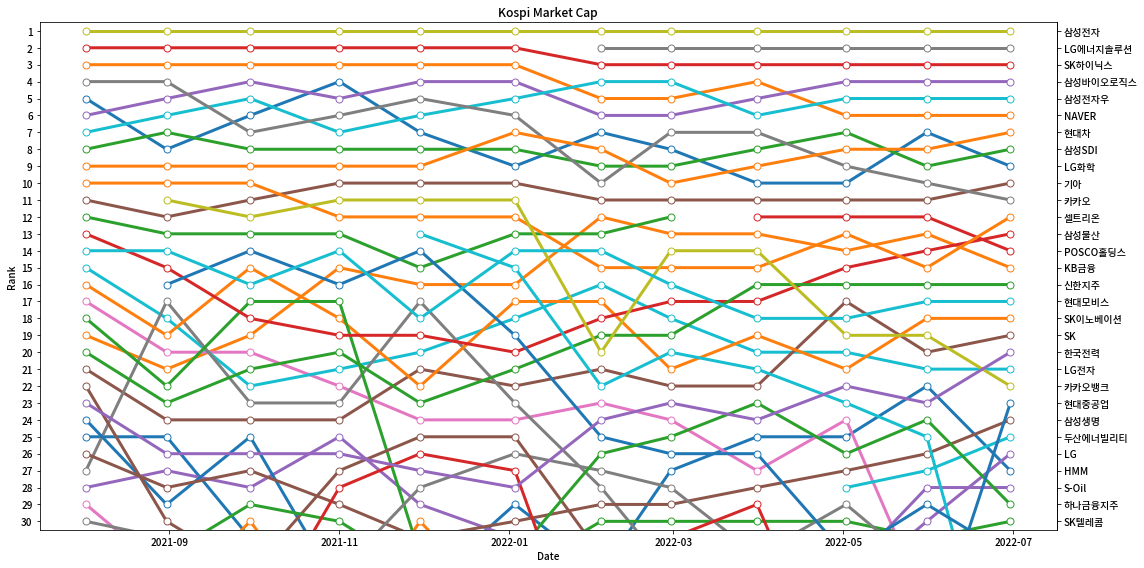

In [200]:
kospi_marketcap_ranking_df = get_ranking_df(previous_year, today, freq='1M', market='kospi', ranking_type='marketcap')
plot_bump(kospi_marketcap_ranking_df, 30, "Kospi Market Cap")

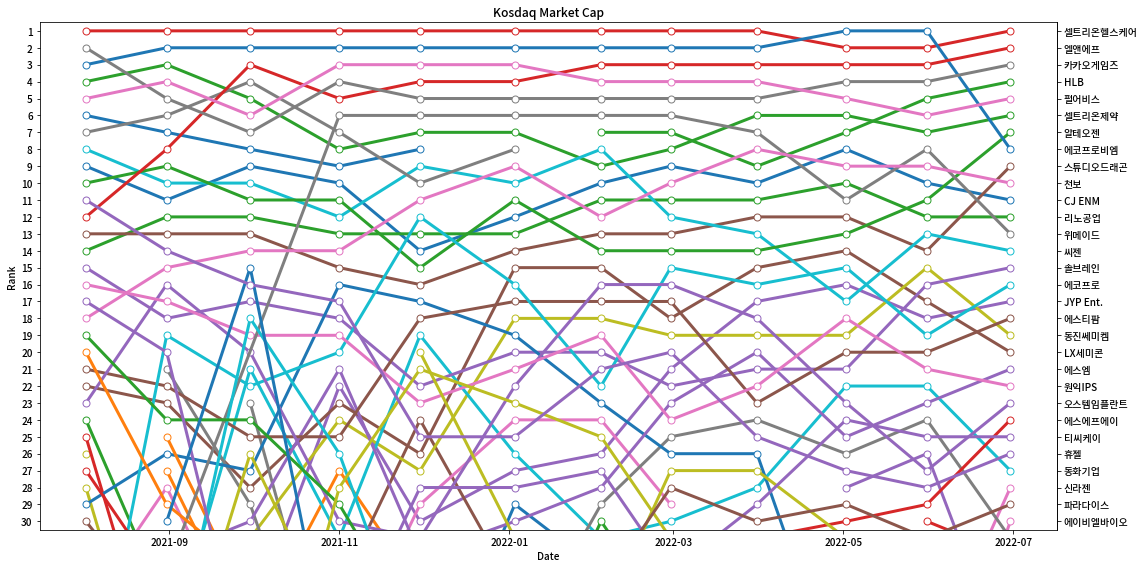

In [201]:
kosdaq_marketcap_ranking_df = get_ranking_df(previous_year, today, freq='1M', market='kosdaq', ranking_type='marketcap')
plot_bump(kosdaq_marketcap_ranking_df, 30, "Kosdaq Market Cap")

Annual King

In [202]:
get_ranking(market_type['kospi'], 'traded', previous_year, today).sort_values('등락률', ascending=False).head(10)

,순위,종목코드,종목명,시장구분,시작일기준가,종료일종가,대비,등락률,거래량_합계,거래량_일평균,거래대금_합계,거래대금_일평균
10,11,249420,일동제약,KOSPI,15650,47750,32100,205.11,752647104,3047154,34211629022900,138508619526
26,27,11700,한신기계,KOSPI,3035,8500,5465,180.07,2278080966,9223000,15841988255460,64137604273
15,16,11070,LG이노텍,KOSPI,223500,341000,117500,52.57,85247360,345131,26739849676727,108258500715
43,44,5070,코스모신소재,KOSPI,37450,51500,14050,37.52,237761639,962598,11285621775150,45690776418
23,24,93370,후성,KOSPI,12500,16300,3800,30.40,889544412,3601394,17707535347650,71690426509
36,37,52690,한전기술,KOSPI,52800,64400,11600,21.97,169201903,685028,13128945765900,53153626583
40,41,10060,OCI,KOSPI,116000,116000,0,0.00,97147320,393309,11709904444300,47408520017
28,29,17670,SK텔레콤,KOSPI,55212,53500,-1712,-3.10,160209053,648620,15014636396173,60788001604
25,26,207940,삼성바이오로직스,KOSPI,853888,817000,-36888,-4.32,18588642,75258,16168941428269,65461301329
42,43,20150,일진머티리얼즈,KOSPI,75700,68400,-7300,-9.64,121200289,490689,11584270206400,46899879378


In [203]:
get_ranking(market_type['kosdaq'], 'traded', previous_year, today).sort_values('등락률', ascending=False).head(10)

,순위,종목코드,종목명,시장구분,시작일기준가,종료일종가,대비,등락률,거래량_합계,거래량_일평균,거래대금_합계,거래대금_일평균
33,34,258830,세종메디칼,KOSDAQ,2080,6200,4120,198.08,1620826537,6562051,9894475226580,40058604156
29,30,5860,한일사료,KOSDAQ,2305,6100,3795,164.64,1639732292,6638592,10799923314550,43724385889
22,23,90710,휴림로봇,KOSDAQ,1120,2695,1575,140.63,5558242850,22503007,13240025500341,53603342107
38,39,278650,노터스,KOSDAQ,3092,7300,4208,136.09,579180900,2344862,9108075998360,36874801613
0,1,112040,위메이드,KOSDAQ,27986,60000,32014,114.39,326853553,1323294,40522075803172,164056987057
19,20,53050,지에스이,KOSDAQ,2130,4490,2360,110.80,2956042947,11967785,14126985168367,57194271937
23,24,307750,국전약품,KOSDAQ,5160,9640,4480,86.82,1127863030,4566247,12548291937670,50802801367
2,3,247540,에코프로비엠,KOSDAQ,60436,111500,51064,84.49,101242073,409887,36553330871119,147989193810
1,2,66970,엘앤에프,KOSDAQ,116500,207500,91000,78.11,212228797,859226,40436726433802,163711443052
36,37,222800,심텍,KOSDAQ,23250,38100,14850,63.87,228295162,924272,9153077261450,37056992961


Montly King

In [204]:
get_ranking(market_type['kospi'], 'traded', previous_month, today).sort_values('등락률', ascending=False).head(10)

,순위,종목코드,종목명,시장구분,시작일기준가,종료일종가,대비,등락률,거래량_합계,거래량_일평균,거래대금_합계,거래대금_일평균
11,12,249420,일동제약,KOSPI,37100,47750,10650,28.71,62548396,2719495,2348540070350,102110437841
2,3,302440,SK바이오사이언스,KOSPI,109500,137000,27500,25.11,30913106,1344048,3958661681800,172115725296
14,15,68270,셀트리온,KOSPI,156000,186500,30500,19.55,12311474,535281,2145678370024,93290363914
31,32,51900,LG생활건강,KOSPI,651000,711000,60000,9.22,1854163,80616,1242228542922,54009936649
4,5,5380,현대차,KOSPI,171500,183500,12000,7.00,20924339,909754,3718781892196,161686169226
28,29,207940,삼성바이오로직스,KOSPI,784000,817000,33000,4.21,1615718,70249,1313571980815,57111825253
5,6,6400,삼성SDI,KOSPI,531000,548000,17000,3.20,5986247,260272,3251369187000,141363877696
41,42,12330,현대모비스,KOSPI,205500,211500,6000,2.92,4971856,216168,1006882966882,43777520299
9,10,270,기아,KOSPI,78000,79100,1100,1.41,32325177,1405442,2519906125883,109561135908
44,45,17670,SK텔레콤,KOSPI,53700,53500,-200,-0.37,17887334,777710,952816773614,41426816244


In [205]:
get_ranking(market_type['kosdaq'], 'traded', previous_month, today).sort_values('등락률', ascending=False).head(10)

,순위,종목코드,종목명,시장구분,시작일기준가,종료일종가,대비,등락률,거래량_합계,거래량_일평균,거래대금_합계,거래대금_일평균
45,46,257720,실리콘투,KOSDAQ,2258,6870,4612,204.25,30559601,1328678,680109031010,29569957870
12,13,44060,조광ILI,KOSDAQ,1463,3605,2142,146.41,111887648,4864680,1446035267345,62871098580
49,50,253840,수젠텍,KOSDAQ,10300,18050,7750,75.24,40019845,1739993,635788595710,27642982422
7,8,205470,휴마시스,KOSDAQ,12450,21550,9100,73.09,126264755,5489772,2281946745050,99215075872
26,27,56700,신화인터텍,KOSDAQ,2745,4425,1680,61.20,249416066,10844177,967978785550,42086034154
30,31,84650,랩지노믹스,KOSDAQ,6070,9220,3150,51.89,107221996,4661826,851958788420,37041686453
36,37,376180,피코그램,KOSDAQ,23350,34550,11200,47.97,22845502,993283,767441807300,33367035100
25,26,256840,한국비엔씨,KOSDAQ,8670,12650,3980,45.91,90307269,3926403,974756915930,42380735475
24,25,64550,바이오니아,KOSDAQ,25450,36850,11400,44.79,27524564,1196720,983394955300,42756302404
42,43,950130,엑세스바이오,KOSDAQ,14950,21500,6550,43.81,37506451,1630715,701837010500,30514652630


Weekly King

In [206]:
get_ranking(market_type['kospi'], 'traded', previous_week, today).sort_values('등락률', ascending=False).head(10)

,순위,종목코드,종목명,시장구분,시작일기준가,종료일종가,대비,등락률,거래량_합계,거래량_일평균,거래대금_합계,거래대금_일평균
3,4,249420,일동제약,KOSPI,30900,47750,16850,54.53,37339170,6223195,1524603654800,254100609133
27,28,230,일동홀딩스,KOSPI,21650,31900,10250,47.34,10327160,1721193,301999367550,50333227925
9,10,11000,진원생명과학,KOSPI,11050,15300,4250,38.46,39674174,6612362,565421074350,94236845725
26,27,12330,현대모비스,KOSPI,193500,211500,18000,9.30,1480531,246755,307643861000,51273976833
37,38,5070,코스모신소재,KOSPI,48000,51500,3500,7.29,4121241,686874,205856796800,34309466133
8,9,373220,LG에너지솔루션,KOSPI,373500,400000,26500,7.10,1634411,272402,645445762000,107574293667
17,18,137310,에스디바이오센서,KOSPI,44200,47000,2800,6.33,8204256,1367376,391632409650,65272068275
2,3,660,SK하이닉스,KOSPI,93900,98700,4800,5.11,16814922,2802487,1602009882400,267001647067
5,6,5380,현대차,KOSPI,175000,183500,8500,4.86,4514600,752433,817319805696,136219967616
11,12,270,기아,KOSPI,75700,79100,3400,4.49,7075578,1179263,556045832500,92674305417


In [207]:
get_ranking(market_type['kosdaq'], 'traded', previous_week, today).sort_values('등락률', ascending=False).head(10)

,순위,종목코드,종목명,시장구분,시작일기준가,종료일종가,대비,등락률,거래량_합계,거래량_일평균,거래대금_합계,거래대금_일평균
4,5,256840,한국비엔씨,KOSDAQ,7950,12650,4700,59.12,70879490,11813248,825315717240,137552619540
28,29,258830,세종메디칼,KOSDAQ,4005,6200,2195,54.81,55680468,9280078,279607082560,46601180427
23,24,44060,조광ILI,KOSDAQ,2339,3605,1266,54.13,23087608,3847935,309395359875,51565893313
11,12,32300,한국파마,KOSDAQ,25450,38550,13100,51.47,12622840,2103807,445633928300,74272321383
3,4,64550,바이오니아,KOSDAQ,26300,36850,10550,40.11,21717691,3619615,838862813100,139810468850
34,35,38070,서린바이오,KOSDAQ,12500,17400,4900,39.20,12330273,2055046,201255012200,33542502033
10,11,307750,국전약품,KOSDAQ,7150,9640,2490,34.83,50394921,8399154,455631824750,75938637458
15,16,261780,차백신연구소,KOSDAQ,6310,8360,2050,32.49,51448612,8574769,404540458310,67423409718
7,8,950130,엑세스바이오,KOSDAQ,16300,21500,5200,31.90,26676154,4446026,536340233800,89390038967
38,39,94480,갤럭시아머니트리,KOSDAQ,5980,7600,1620,27.09,23718048,3953008,179266176680,29877696113


Sector Momentum Ranking

In [214]:
sector_dic = {'에너지': 'WI100', '화학': 'WI110', '비철금속': 'WI200', '철강': 'WI210', '건설': 'WI220', '기계': 'WI230', '조선': 'WI240', '상가,자본재': 'WI250', \
       '운송': 'WI260', '자동차': 'WI300', '화장품,의류': 'WI310', '호텔,레저': 'WI320', '미디어,교육': 'WI330', '소매(유통)': 'WI340', '필수소비재': 'WI400', \
       '건강관리': 'WI410', '은행': 'WI500', '증권': 'WI510', '보험': 'WI520', '소프트웨어': 'WI600', 'IT하드웨어': 'WI610', '반도체': 'WI620', 'IT가전': 'WI630', \
       '디스플레이': 'WI640', '전기통신서비스': 'WI700', '유틸리티': 'WI800'}

sheets = ['Index Value', 'Return', 'Valuation Ratio', 'Risk & Performance Ratio']

In [215]:
def get_sector(sector, term, current_date, pre_year=3):
  id = sector_dic[sector]
  name = 'WI26' + sector
  current_date = current_date if XKRX.is_session(current_date) else XKRX.previous_open(current_date)
  previous_date = (datetime.strptime(current_date, '%Y%m%d') - relativedelta.relativedelta(years=pre_year))
  previous_date = previous_date if XKRX.is_session(previous_date) else XKRX.next_open(previous_date)

  current_date = datetime.strptime(current_date, '%Y%m%d').strftime('%Y-%m-%d') \
  if type(current_date) == str else current_date.strftime('%Y-%m-%d')
  previous_date = datetime.strptime(previous_date, '%Y%m%d').strftime('%Y-%m-%d') \
  if type(previous_date) == str else previous_date.strftime('%Y-%m-%d')
  t = {
      'day' : '1',
      'week' : '2',
      'month' : '3',
      'quarter' : '4'
  }
  headers = {'User-Agent' : 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36'}
  url = 'https://www.wiseindex.com/DataCenter/ExportToExcel?index_ids=' + \
    id + '&index_names=' + name + '&tabs=1,2,3,4&fromDT=' + \
    previous_date + '&endDT=' + current_date + '&term=' + t[term] + '&isEnd=1'
  res = requests.get(url, headers = headers)
  xls = pd.ExcelFile(res.content)
  return xls

In [210]:
energy = get_sector('에너지', 'month', today, 3)

In [211]:
def get_sheet(elx, sheets):
  df = pd.read_excel(elx, sheets) 
  df.columns = df.iloc[0]
  df = df.iloc[::-1]
  df = df.drop(0)
  df = df[1:].set_index('일자')
  return df

In [223]:
df = get_sheet(energy, sheets[0])
df

,지수값,시가총액 (백만),거래대금 (백만)
일자,,,
2019-08-30,4414.41,20417671.84,211597.21
2019-09-30,4537.18,20988519.6,292596.52
2019-10-31,4640.5,21494274.69,240433.81
2019-11-29,4293.83,19955096.54,270349.67
2019-12-30,4413.17,19569272.19,115946.86
2020-01-31,3770.54,16762537.6,395467.98
2020-02-28,3373.2,15054586.67,242022.74
2020-03-31,2717.37,12179678.11,231664.2
2020-04-29,3136.36,14057644.33,276590.91


In [224]:
sectors = {}
for sector in list(sector_dic):
  sectors[sector] = get_sheet(get_sector(sector, 'month', today, 3), sheets[0])

In [226]:
sectors['화학']

,지수값,시가총액 (백만),거래대금 (백만)
일자,,,
2019-08-30,3178.17,37258367.01,290991.03
2019-09-30,3061.91,36060825.56,313305.96
2019-10-31,3099.85,36509406.92,306024.7
2019-11-29,3094.06,36474915.83,339151.41
2019-12-30,3203.94,37667016.7,280683.94
2020-01-31,3147.63,37017535.2,877913.77
2020-02-28,3136.58,36888580.74,828265.39
2020-03-31,2746.34,32474170.05,1020319.14
2020-04-29,3279.7,38781254.89,1235716.98


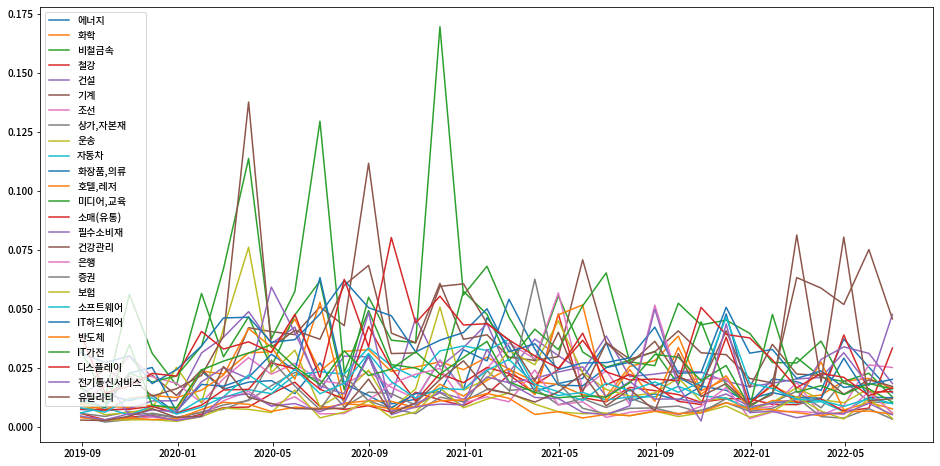

In [230]:
plt.figure(figsize=(16, 8))
for sector in list(sector_dic):
  plt.plot(sectors[sector]['거래대금 (백만)']/sectors[sector]['시가총액 (백만)'])
plt.legend(list(sector_dic))
plt.show()

In [251]:
t = {}
for date in sectors[sector].index:
  d = dict(zip(list(sector_dic), [(sectors[x]['거래대금 (백만)']/sectors[x]['시가총액 (백만)'])[date] for x in list(sector_dic)]))
  t[date] = sorted(d.items(), key=lambda kv: kv[1], reverse=True)

In [255]:
pd.DataFrame(t).T

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
2019-08-30,"(디스플레이, 0.0392883146644686)","(비철금속, 0.0327635406873043)","(IT하드웨어, 0.03139779158168318)","(미디어,교육, 0.016700056672917046)","(기계, 0.01630032885240742)","(필수소비재, 0.013881664046811508)","(화장품,의류, 0.012396876412111466)","(건강관리, 0.012082613045712697)","(IT가전, 0.010870779069702692)","(조선, 0.010802662375595896)",...,"(건설, 0.007457231032303468)","(자동차, 0.006045549858121339)","(상가,자본재, 0.005797391453416299)","(철강, 0.005738069632439829)","(전기통신서비스, 0.004614682024330593)","(증권, 0.004590452657702272)","(은행, 0.004460270576657707)","(보험, 0.004212381066297805)","(반도체, 0.004001094795311048)","(유틸리티, 0.00295557511892203)"
2019-09-30,"(IT하드웨어, 0.02728926977770315)","(기계, 0.02458885162971841)","(필수소비재, 0.019619613373455504)","(조선, 0.01724407151524718)","(디스플레이, 0.01445344744201502)","(에너지, 0.013940788849157327)","(비철금속, 0.012572570148177633)","(건강관리, 0.01237665301109814)","(미디어,교육, 0.010185252647161028)","(화학, 0.008688263652719325)",...,"(소프트웨어, 0.006305478237926651)","(운송, 0.0052203889465675425)","(상가,자본재, 0.0045313285813496475)","(전기통신서비스, 0.003095793836192394)","(철강, 0.003084280406768142)","(반도체, 0.0030621559191648965)","(보험, 0.003011296415490257)","(유틸리티, 0.0027781300031739925)","(은행, 0.0027763532567042755)","(증권, 0.0021465406292080903)"
2019-10-31,"(비철금속, 0.05621449051457286)","(IT가전, 0.03494368448869295)","(조선, 0.03021405708145397)","(IT하드웨어, 0.030147745562659388)","(화장품,의류, 0.022835672079220198)","(미디어,교육, 0.022824815569334935)","(건강관리, 0.021596346028838694)","(기계, 0.018655714511692487)","(디스플레이, 0.01735128061980784)","(호텔,레저, 0.012217607907628233)",...,"(운송, 0.006203019953958688)","(전기통신서비스, 0.005680575579403393)","(필수소비재, 0.0051126084792499195)","(자동차, 0.005067377332345944)","(유틸리티, 0.0046088747658771185)","(철강, 0.004206303669798889)","(반도체, 0.003891988752786067)","(은행, 0.0034315068670341094)","(증권, 0.0032028187234641333)","(보험, 0.003062718336230512)"
2019-11-29,"(비철금속, 0.031247375739940488)","(화장품,의류, 0.02524713834134071)","(디스플레이, 0.022737830607477076)","(기계, 0.022001211697145247)","(조선, 0.02132100289162088)","(미디어,교육, 0.01907450115709943)","(IT하드웨어, 0.018399918915992183)","(에너지, 0.013547900881265293)","(호텔,레저, 0.013445105716907955)","(건강관리, 0.013116390956934731)",...,"(운송, 0.008017179608754168)","(유틸리티, 0.007808848846665085)","(필수소비재, 0.007246555457627488)","(증권, 0.005905615765835391)","(상가,자본재, 0.005448686931424976)","(철강, 0.004905121162117076)","(전기통신서비스, 0.004679121209987918)","(은행, 0.0042680129362282345)","(반도체, 0.0031874697075003743)","(보험, 0.003099856349823486)"
2019-12-30,"(운송, 0.02528663091863096)","(IT하드웨어, 0.02430342970240403)","(미디어,교육, 0.021651143124679004)","(디스플레이, 0.02158638375289176)","(조선, 0.018573927501148585)","(비철금속, 0.017757662245349977)","(건강관리, 0.016259189069075888)","(기계, 0.013395394181144512)","(호텔,레저, 0.012494962092868574)","(건설, 0.011170418326614346)",...,"(자동차, 0.005584369101578932)","(소프트웨어, 0.005542018692851633)","(증권, 0.004135474122243168)","(유틸리티, 0.0040918138758691295)","(상가,자본재, 0.003897115035198047)","(반도체, 0.003544523886526461)","(은행, 0.003291315310124281)","(전기통신서비스, 0.0028022262097725887)","(철강, 0.0027207428201587386)","(보험, 0.0024343554931309692)"
2020-01-31,"(비철금속, 0.05657859719267472)","(디스플레이, 0.04047227883553716)","(IT하드웨어, 0.03435745659428992)","(미디어,교육, 0.03426328821244306)","(건설, 0.03139383728222552)","(기계, 0.02423226663233407)","(IT가전, 0.024200252448908905)","(화학, 0.02371615952431106)","(에너지, 0.023592369451269718)","(건강관리, 0.021874605453670135)",...,"(소매(유통), 0.009318143809556877)","(소프트웨어, 0.008468986041908402)","(반도체, 0.00745480389309196)","(증권, 0.00633426821354937)","(상가,자본재, 0.006281360726762907)","(철강, 0.005499044453798691)","(은행, 0.004758333348461423)","(유틸리티, 0.004677154206381522)","(전기통신서비스, 0.004489672693236242)","(보험, 0.0044491280218794515)"
2020-02-28,"(미디어,교육, 0.06705797430958059)","(IT하드웨어, 0.046198434810798446)","(운송, 0.04174607445046605)","(건강관리, 0.03852825390366312)","(건설, 0.038038178661336845)","(디스플레이, 0

[('건설', 0.047703489675593326),
 ('기계', 0.04581310204102228),
 ('소매(유통)', 0.033435477754465155),
 ('조선', 0.025236876449759787),
 ('IT하드웨어', 0.020231615981380766),
 ('필수소비재', 0.01842633885599452),
 ('건강관리', 0.01721367024993635),
 ('디스플레이', 0.01661489059270137),
 ('화학', 0.016386371122188166),
 ('IT가전', 0.01610179963031693),
 ('철강', 0.014985233886108972),
 ('에너지', 0.0145226919317822),
 ('비철금속', 0.012724319965007412),
 ('화장품,의류', 0.012445291350138863),
 ('유틸리티', 0.011994097866029318),
 ('미디어,교육', 0.01056905761434406),
 ('상가,자본재', 0.01011575091746559),
 ('자동차', 0.009973858580371715),
 ('소프트웨어', 0.0099302020415104),
 ('호텔,레저', 0.007739316993739404),
 ('은행', 0.005977892282319826),
 ('운송', 0.005709698612818886),
 ('반도체', 0.005442553812385399),
 ('전기통신서비스', 0.0052503228622124715),
 ('보험', 0.0036504327427212876),
 ('증권', 0.0033440098854756717)]